In [1]:
import matplotlib.pyplot as plt
import optax
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import StronglyEntanglingLayers
import jax
import jax.numpy as jnp
from functools import partial

np.random.seed(42)

key = jax.random.PRNGKey(42)

In [2]:
degree = 5
scaling = 1
coeffs = [0.05 + 0.05j] * degree
coeffs = [
    (1.29 + 1.13j),  # c_1
    (0.43 + 0.89j),  # c_2
    (1.97 + 1.03j),  # c_3
    (0.17 + 0.59j),  # c_4
    (1.71 + 1.41j),  # c_5
    (0.61 + 0.37j),  # c_6
    (1.19 + 1.67j),  # c_7
    (0.73 + 1.61j),  # c_8
    (0.23 + 0.47j),  # c_9
    (1.83 + 0.83j),  # c_10
]
c0 = 0.0


def target_function(x):
    res = c0
    for idx, c in enumerate(coeffs):
        exponent = scaling * (idx + 1) * x * 1j
        conj_c = jnp.conjugate(c)
        res += c * jnp.exp(exponent) + conj_c * jnp.exp(-exponent)
    return jnp.real(res)

def minmax_scaler(y):
    # Scale y to [0, 1]
    y_min = jnp.min(y)
    y_max = jnp.max(y)
    y_scaled = (y - y_min) / (y_max - y_min)
    return y_scaled

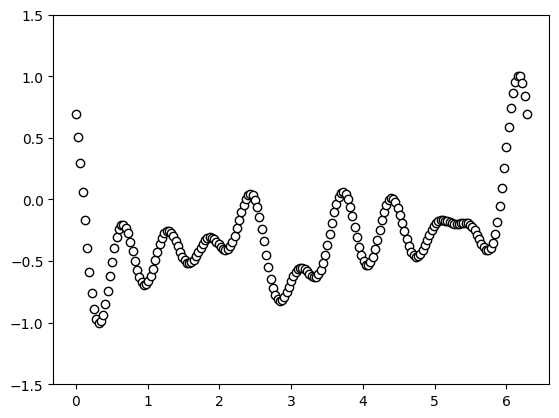

In [3]:
x_raw = jnp.linspace(-12, 12, 200)
x = minmax_scaler(x_raw) * 2 * jnp.pi
target_y = jax.vmap(target_function)(x)

target_y_scaled = minmax_scaler(target_y) * 2 - 1

# plt.plot(x, target_y, c="black")
plt.scatter(x, target_y_scaled, facecolor="white", edgecolor="black")
plt.ylim(-1.5, 1.5)
plt.show()

In [4]:
n_ansatz_layers = 1
n_qubits = 3

dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev)
def ansatz(weights):
    StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.expval(qml.Identity(wires=0))

key, subkey = jax.random.split(key)

weights_ansatz = 2 * jnp.pi * jax.random.uniform(subkey, (n_ansatz_layers, n_qubits, 3))
print(qml.draw(ansatz, level="device")(weights_ansatz))

0: ──Rot(0.30,3.72,2.53)─╭●────╭X─┤  <I>
1: ──Rot(4.23,2.22,3.84)─╰X─╭●─│──┤     
2: ──Rot(2.87,4.50,3.98)────╰X─╰●─┤     


In [5]:
scaling = 1
r = 10

dev = qml.device("default.qubit", wires=r)

def S(x):
    """encoding block"""
    for w in range(r):
        qml.RX(scaling * x, wires=w)

def W(theta):
    """train block"""
    StronglyEntanglingLayers(theta, wires=range(r))

@qml.qnode(dev, interface="jax")
def parallel_quantum_model(weights, x):
    W(weights[0])
    S(x)
    W(weights[1])
    # for theta in weights[:-1]:
    #     W(theta)
    #     S(x)
    #
    # # (L+1)'th unitary
    # W(weights[-1])

    return qml.expval(qml.PauliZ(wires=0))

jit_model = jax.jit(parallel_quantum_model)
# @jax.jit
# def jit_model(weights, x):
#     raw_outputs = parallel_quantum_model(weights, x)
#     return jnp.mean(jnp.stack(raw_outputs))

0: ──Rot(1.84,5.24,0.31)─╭●─────────────────────────╭X──Rot(6.19,1.09,2.41)─╭●────────────────── ···
1: ──Rot(3.89,1.01,5.72)─╰X─╭●──────────────────────│───Rot(6.11,0.33,0.37)─│──╭●─────────────── ···
2: ──Rot(2.35,0.78,0.42)────╰X─╭●───────────────────│───Rot(3.54,0.65,5.49)─╰X─│──╭●──────────── ···
3: ──Rot(1.86,4.79,2.41)───────╰X─╭●────────────────│───Rot(0.28,5.06,1.59)────╰X─│──╭●───────── ···
4: ──Rot(2.08,0.88,3.00)──────────╰X─╭●─────────────│───Rot(2.40,3.82,5.76)───────╰X─│──╭●────── ···
5: ──Rot(5.28,2.59,4.91)─────────────╰X─╭●──────────│───Rot(2.14,3.01,3.66)──────────╰X─│──╭●─── ···
6: ──Rot(4.58,5.31,2.06)────────────────╰X─╭●───────│───Rot(0.49,6.08,2.08)─────────────╰X─│──╭● ···
7: ──Rot(1.64,2.19,2.87)───────────────────╰X─╭●────│───Rot(5.72,5.33,2.21)────────────────╰X─│─ ···
8: ──Rot(2.06,5.55,0.04)──────────────────────╰X─╭●─│───Rot(2.76,5.48,3.87)───────────────────╰X ···
9: ──Rot(3.43,3.21,6.12)─────────────────────────╰X─╰●──Rot(4.91,1.29,0.45)────────────────

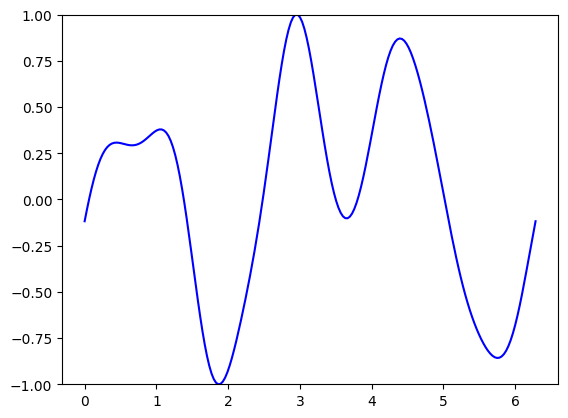

In [6]:
trainable_block_layers = 3
key, subkey = jax.random.split(key)
weights = 2 * jnp.pi * jax.random.uniform(subkey, shape=(2, trainable_block_layers, r, 3))

print(qml.draw(parallel_quantum_model, level="device")(weights, x))

random_quantum_model_y = jax.vmap(lambda x_: jit_model(weights, x_))(x)
random_quantum_model_y_scaled = minmax_scaler(random_quantum_model_y) * 2 - 1

plt.plot(x, random_quantum_model_y_scaled, c="blue")
plt.ylim(-1, 1)
plt.show()

In [18]:
def square_loss(targets, predictions):
    return 0.5 * jnp.mean((targets - predictions) ** 2)

def cost (weights, x, y):
    # predictions = jax.vmap(lambda x_: jit_model(weights, x_))(x)
    predictions = jit_model(weights, x)
    return square_loss(y, predictions)

class GradientLogger:
    def __init__(self):
        self.log = {
            "step": [],
            "loss": [],
            "grad_mean": [],
            "grad_std": [],
            "grad_min": [],
            "grad_max": [],
        }

    def get_gradients(self, weights, x, target_y):
        cost_fn = lambda w: cost(w, x, target_y)
        grads = jax.grad(cost_fn)(weights)

        # Flatten all gradient arrays into a single vector
        flat_grads = jnp.concatenate([jnp.ravel(g) for g in jax.tree_util.tree_leaves(grads)])

        return flat_grads

    def update(self, step, loss_val, flat_grads):
        self.log["step"].append(step)
        self.log["loss"].append(loss_val)
        self.log["grad_mean"].append(jnp.mean(flat_grads))
        self.log["grad_std"].append(jnp.std(flat_grads))
        self.log["grad_min"].append(jnp.min(flat_grads))
        self.log["grad_max"].append(jnp.max(flat_grads))

    def summary(self):
        return self.log

In [18]:
class EffectiveDimension:
    def __init__(self, model_fn, input_sampler, param_sampler, d, input_dim, num_weight_samples, num_input_samples):

        self.model_fn = model_fn
        self.input_sampler = input_sampler
        self.param_sampler = param_sampler
        self.d = d
        self.input_dim = input_dim
        self.num_thetas = num_weight_samples
        self.num_inputs = num_input_samples

    # def _flatten_grad(self, grad_tree):
        # """Flatten gradient PyTree into a 1D vector."""
        # return jnp.concatenate([jnp.ravel(g) for g in jax.tree_util.tree_leaves(grad_tree)])

    def compute_fhat(self, key):
        """
        normalized Fisher matrix F_hat
        Returns:
        - f_hat: [d, d] array, normalized Fisher matrix
        - fisher_trace: scalar, average trace before normalization
        """
        key_thetas, key_inputs = jax.random.split(key)

        # Sample parameter sets and inputs
        param_sets = self.param_sampler(key_thetas, self.num_thetas)
        input_set = self.input_sampler(key_inputs, self.num_inputs)
        y = jax.vmap(target_function)(input_set)
        y_scaled = minmax_scaler(y) * 2 - 1
        logger = GradientLogger()

        def fisher(params):
            # grads = jax.vmap(lambda x: self._flatten_grad(jax.grad(lambda w: self.model_fn(w, x))(params)))(input_set)
            grads = jax.vmap(lambda x, y_: logger.get_gradients(params, x, y_))(input_set, y_scaled)
            F = jnp.einsum('ni,nj->ij', grads, grads) / grads.shape[0]
            return F

        fisher_matrices = jax.vmap(fisher)(param_sets)
        fisher_mean = jnp.mean(fisher_matrices, axis=0)
        fisher_trace = jnp.trace(fisher_mean)

        f_hat = self.d * fisher_mean / fisher_trace
        return f_hat, fisher_trace

    def compute_effective_dimension(self, f_hat, n_list):
        """
        Parameters:
        - f_hat: [d, d] array, normalized Fisher matrix
        - n_list: list or array of sample sizes

        Returns:
        - List of effective dimensions
        """
        eds = []
        eye = jnp.eye(self.d)

        for n in n_list:
            scale = n / (2 * jnp.pi * jnp.log(n))
            mat = eye + scale * f_hat
            sign, logdet = jnp.linalg.slogdet(mat)
            r_ = 0.5 * logdet * sign
            ed = 2 * (r_ - jnp.log(self.num_thetas)) / jnp.log(n / (2 * jnp.pi * jnp.log(n)))
            eds.append(ed)

        return jnp.array(eds)

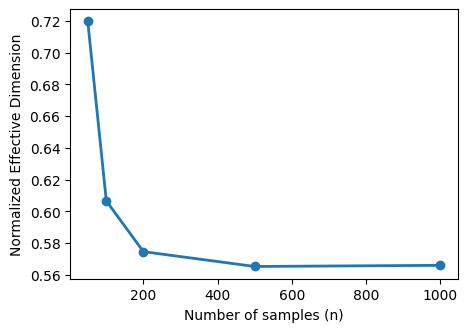

In [55]:
# weights.shape = (2, L, r, 3) -> total params d = 2 * L * r * 3
d = weights.size

# model function
model_fn = lambda w, x: parallel_quantum_model(w, x)

# Define input and parameter samplers
def input_sampler(key, num_inputs):
    return jax.random.uniform(key, shape=(num_inputs,), minval=0.0, maxval=2*jnp.pi)

def param_sampler(key, num_thetas):
    return jax.random.uniform(key, shape=(num_thetas, 2, trainable_block_layers, r, 3), minval=0.0, maxval=2*jnp.pi)


ed_estimator = EffectiveDimension(
    model_fn=model_fn,
    input_sampler=input_sampler,
    param_sampler=param_sampler,
    d=d,
    input_dim=1,
    num_weight_samples=100,
    num_input_samples=100,
)


fhat, trace = ed_estimator.compute_fhat(key)
n_values = jnp.array([50, 100, 200, 500, 1000])
effective_dims = ed_estimator.compute_effective_dimension(fhat, n_values)

norm_ed = effective_dims / d

# Plot
plt.figure(figsize=(5, 3.5))
plt.plot(n_values, norm_ed, marker='o', linewidth=2)
plt.xlabel("Number of samples (n)")
plt.ylabel("Normalized Effective Dimension")
#plt.xscale("log")  # matches Figure 2’s horizontal log scale
#plt.ylim(0, 1.05)
#plt.grid(True, which="both", linestyle="--", alpha=0.4)
#plt.tight_layout()
plt.show()

In [47]:
def compute_fim(weights, grads, x_data):
    # vmap over inputs to get one gradient vector per sample
    grads = jax.vmap(partial(grads, weights))(x_data)

    # Empirical Fisher: average of outer products of grads
    fim = jnp.einsum('ni,nj->ij', grads, grads) / grads.shape[0]
    return fim


opt = optax.adam(0.01)
opt_state = opt.init(weights)

@jax.jit
def update_step(weights, opt_state, x_batch, y_batch):
    loss, grads = jax.value_and_grad(cost)(weights, x_batch, y_batch)
    updates, opt_state = opt.update(grads, opt_state)
    weights = optax.apply_updates(weights, updates)
    return weights, opt_state, loss

max_steps = 1000
batch_size = 25
cst = [cost(weights, x, target_y)]  # initial cost
logger = GradientLogger()

for step in range(max_steps):
    key, subkey = jax.random.split(key)

    batch_index = jax.random.choice(subkey, len(x), (batch_size,), replace=False)
    x_batch = x[batch_index]
    y_batch = target_y_scaled[batch_index]

    weights, opt_state, _ = update_step(weights, opt_state, x_batch, y_batch)

    c = cost(weights, x, target_y_scaled)
    cst.append(c)

    grads = logger.get_gradients(weights, x, target_y_scaled)
    logger.update(step, c, grads)

    if (step + 1) % 10 == 0:
        print("Cost at step {0:3}: {1}".format(step + 1, c))

Cost at step  10: 0.05546437203884125
Cost at step  20: 0.038176629692316055
Cost at step  30: 0.031021513044834137
Cost at step  40: 0.026680421084165573
Cost at step  50: 0.023653831332921982
Cost at step  60: 0.02146030217409134
Cost at step  70: 0.020109929144382477
Cost at step  80: 0.018296748399734497
Cost at step  90: 0.017587553709745407
Cost at step 100: 0.016378141939640045
Cost at step 110: 0.01576387882232666
Cost at step 120: 0.014991451986134052
Cost at step 130: 0.014587238430976868
Cost at step 140: 0.014426182955503464
Cost at step 150: 0.01363350823521614
Cost at step 160: 0.012793595902621746
Cost at step 170: 0.01255613099783659
Cost at step 180: 0.011585041880607605
Cost at step 190: 0.011439760215580463
Cost at step 200: 0.010781671851873398
Cost at step 210: 0.009951482526957989
Cost at step 220: 0.009495565667748451
Cost at step 230: 0.008880984969437122
Cost at step 240: 0.008106358349323273
Cost at step 250: 0.0076909735798835754
Cost at step 260: 0.006897331

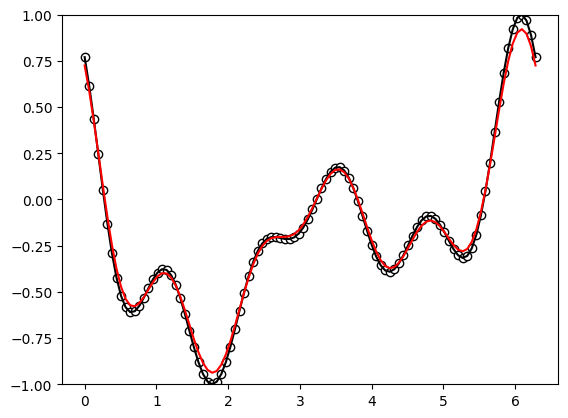

In [48]:
predictions = jax.vmap(lambda x_: jit_model(weights, x_))(x)

plt.plot(x, target_y_scaled, c="black")
plt.scatter(x, target_y_scaled, facecolor="white", edgecolor="black")
plt.plot(x, predictions, c="red")
plt.ylim(-1, 1)
plt.show()

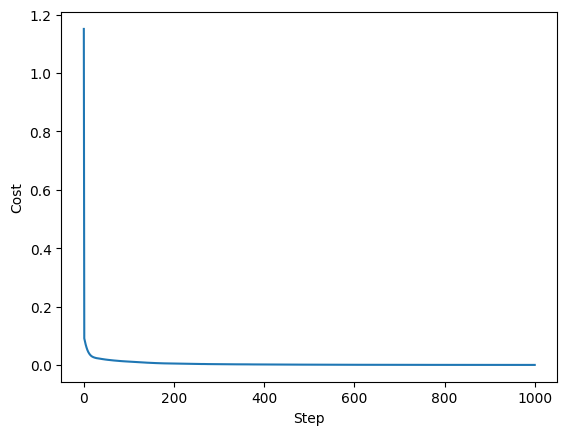

In [26]:
plt.plot(range(len(cst)), cst)
plt.ylabel("Cost")
plt.xlabel("Step")
plt.ylim(0, 0.23)
plt.show()

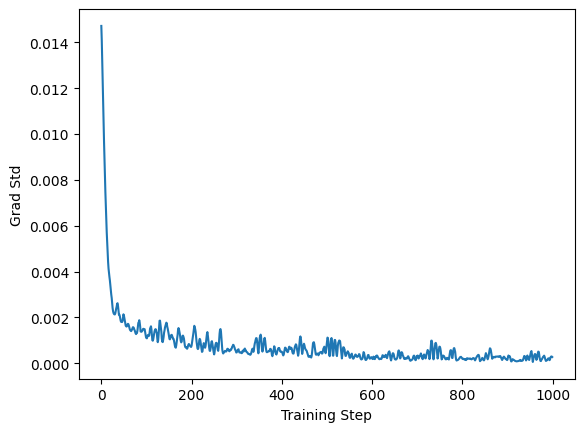

In [27]:
log = logger.summary()

plt.plot(log["step"], log["grad_std"])
plt.xlabel("Training Step")
plt.ylabel("Grad Std")
plt.show()

In [32]:
qfim = qml.gradients.quantum_fisher(parallel_quantum_model)(weights, x)
qfim

ValueError: All input arrays must have the same shape.